In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [7]:
res_1_df = pd.read_csv('results_1.1.csv')

In [8]:
res_1_df.head()

,degree,threads,time_alloc,time_init,time_seq_baseline,time_thread_create,time_compute,time_thread_join,time_cleanup,time_total,user
0,5000,sequential,0.000022,0.001611,0.012571,0.000000,0.000000,0.000000,0.000001,0.014205,marr
1,5000,1,0.000030,0.000271,0.000000,0.000058,0.010114,0.000006,0.000001,0.010481,marr
2,5000,2,0.000031,0.000121,0.000000,0.000102,0.003396,0.000010,0.000000,0.003660,marr
3,5000,4,0.000055,0.000122,0.000000,0.000238,0.006157,0.000024,0.000001,0.006597,marr
4,5000,8,0.000083,0.000144,0.000000,0.000476,0.006392,0.000035,0.000001,0.007131,marr


In [9]:
os.makedirs('plots', exist_ok=True)

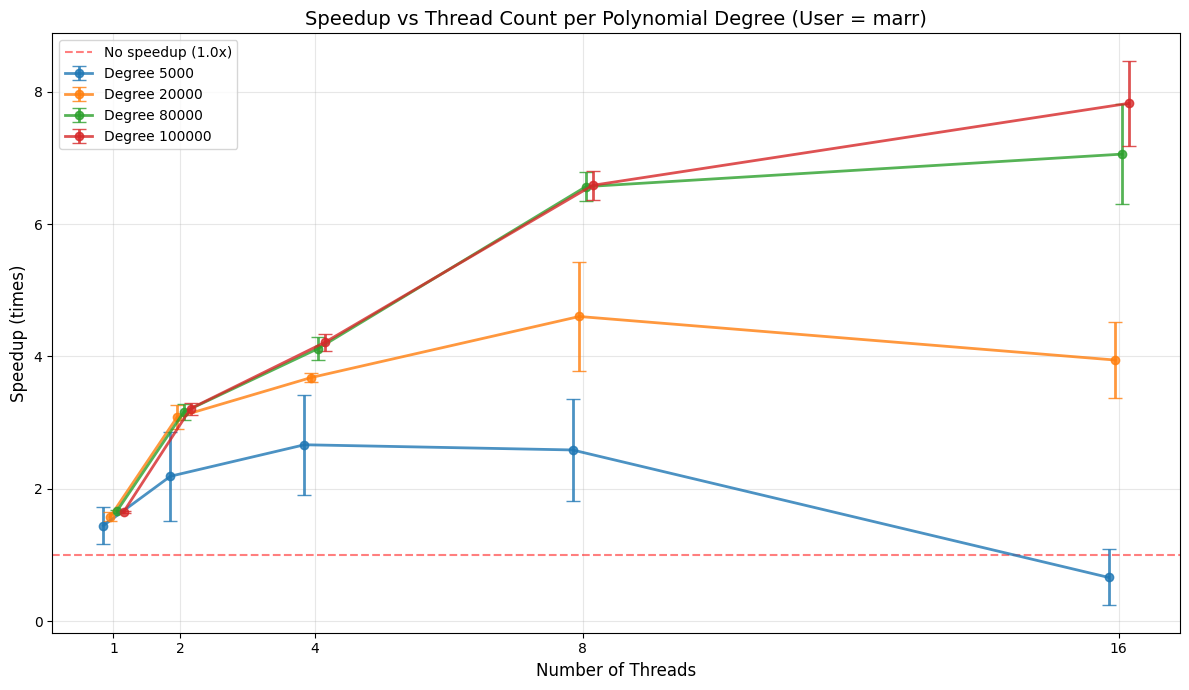

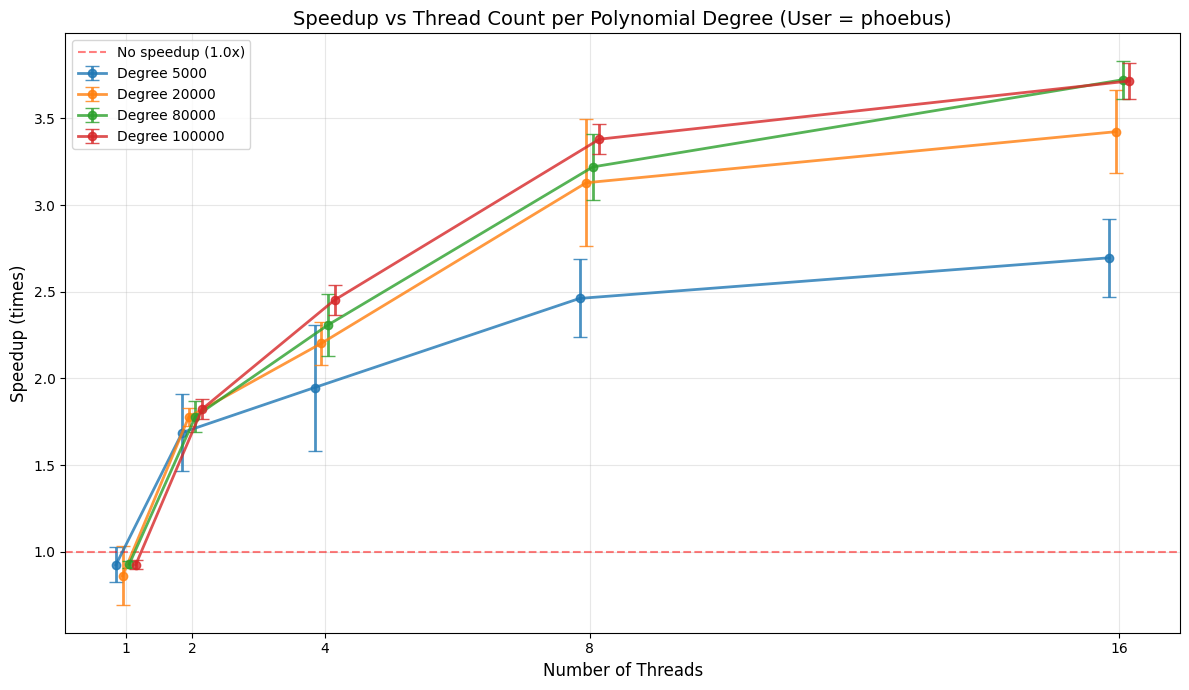

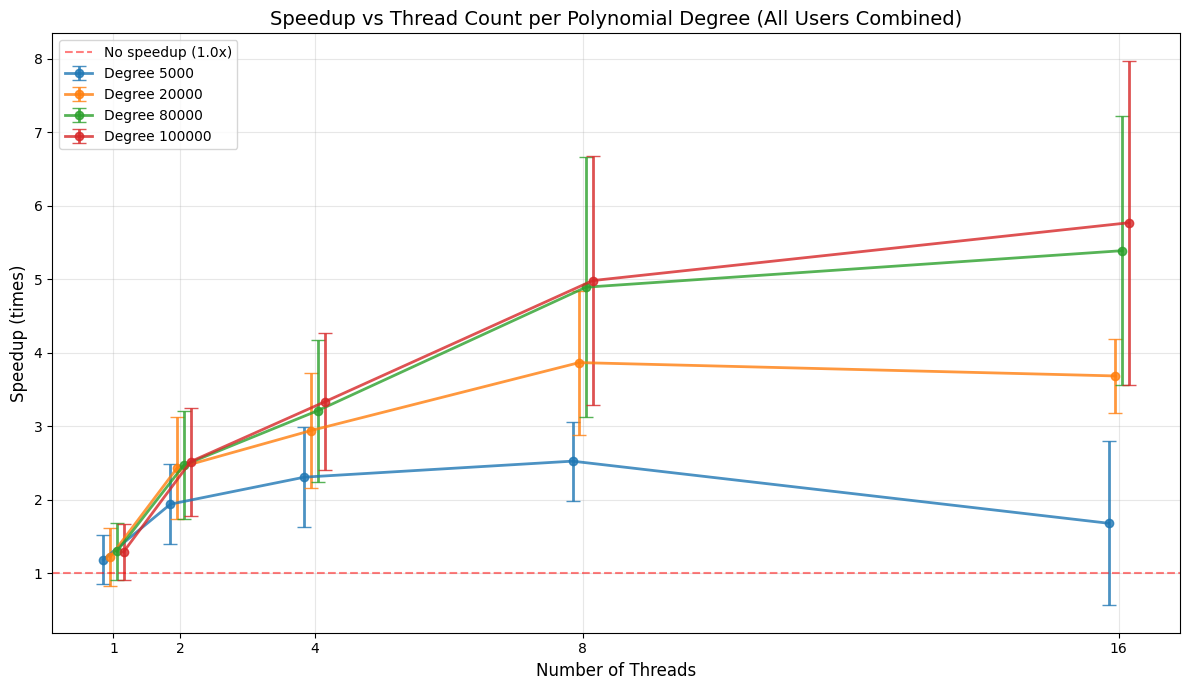


Combined Statistics (Mean ± Std):
 degree  threads     mean      std
   5000        1 1.184834 0.338067
   5000        2 1.938821 0.540138
   5000        4 2.306420 0.676352
   5000        8 2.524274 0.538443
   5000       16 1.678582 1.119434
  20000        1 1.219034 0.396924
  20000        2 2.430333 0.698931
  20000        4 2.941525 0.784875
  20000        8 3.866176 0.979389
  20000       16 3.684429 0.499314
  80000        1 1.294857 0.387541
  80000        2 2.470062 0.734122
  80000        4 3.212499 0.968062
  80000        8 4.892726 1.773225
  80000       16 5.389827 1.829680
 100000        1 1.288103 0.382194
 100000        2 2.517394 0.735585
 100000        4 3.331282 0.931897
 100000        8 4.982527 1.695692
 100000       16 5.770022 2.208217

Unique users: ['marr', 'phoebus']
Plots saved for each user and combined plot.


In [10]:
# Calculate speedup (sequential time / parallel time)
# CRITICAL: For each degree, use the CORRECT sequential baseline time
speedup_data = []

for degree in res_1_df['degree'].unique():
    degree_data = res_1_df[res_1_df['degree'] == degree]
    
    # Get sequential baseline for THIS SPECIFIC DEGREE
    seq_times = degree_data[degree_data['threads'] == 'sequential']['time_total'].values
    
    if len(seq_times) > 0:
        # Use the mean of sequential times for this degree (in case multiple runs)
        seq_time = np.mean(seq_times)
        
        # Calculate speedup for each parallel execution at this degree
        for _, row in degree_data[degree_data['threads'] != 'sequential'].iterrows():
            speedup = seq_time / row['time_total']
            speedup_data.append({
                'degree': degree,
                'threads': int(row['threads']),
                'speedup': speedup,
                'user': row['user']
            })

speedup_df = pd.DataFrame(speedup_data)

# Get unique users
unique_users = speedup_df['user'].unique()

# Create plots for each user
for user in unique_users:
    user_data = speedup_df[speedup_df['user'] == user]
    speedup_stats = user_data.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    # NO conversion to percentage - speedup is dimensionless (e.g., 2.0x)
    
    # Plot speedup with error bars and jitter
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define jitter offset for each degree
    unique_degrees = sorted(speedup_stats['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats[speedup_stats['degree'] == degree].copy()
        # Add jitter to x positions
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean'], 
                    yerr=degree_stats['std'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title(f'Speedup vs Thread Count per Polynomial Degree (User = {user})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats['threads'].unique()))
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'plots/speedup_per_degree_{user}.png', dpi=300)
    plt.show()

# Create combined plot with all users - calculate mean and std across all users
if len(unique_users) > 1:
    speedup_stats_all = speedup_df.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    unique_degrees = sorted(speedup_stats_all['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats_all[speedup_stats_all['degree'] == degree].copy()
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean'], 
                    yerr=degree_stats['std'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title('Speedup vs Thread Count per Polynomial Degree (All Users Combined)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats_all['threads'].unique()))
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('plots/speedup_per_degree_all_users.png', dpi=300)
    plt.show()
    
    print("\nCombined Statistics (Mean ± Std):")
    print(speedup_stats_all[['degree', 'threads', 'mean', 'std']].to_string(index=False))

print(f"\nUnique users: {list(unique_users)}")
print(f"Plots saved for each user and combined plot.")